In [3]:
import pymongo
import dotenv
import os
from guardrail import Guardrail
import pandas as pd

dotenv.load_dotenv()

[nltk_data] Downloading package punkt to /home/bocampagni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/bocampagni/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
atlas = pymongo.MongoClient(os.environ["MONGODB_URI"])
embedding_collection = atlas.get_database("db").get_collection(
    "embeddings"
)

In [5]:
test_dataset = pd.read_csv("./spml_prompt_injection.csv")


In [6]:
guardrail_validation = Guardrail(
    vector_store=embedding_collection,
    similarity_upper_bound=0.4,
    anomaly_upper_bound=0.05,
    entropy_upper_bound=5.8,
)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Inicializa variáveis
y_true = []  # Valores reais (0 = normal, 1 = prompt injection)
y_pred = []  # Predição do framework (0 = permitido, 1 = bloqueado)
success_events = {}
error_events = {}

iterations = []  
simulation = test_dataset[:1000]  # Ajuste para o tamanho desejado

# Loop de validação
for index, row in simulation.iterrows():
    should_block = guardrail_validation.should_block(row["User Prompt"])
    predicted_block = int(should_block.get("blocked"))  # 1 se bloqueado, 0 se não
    actual_label = int(row["Prompt injection"])  # 1 se prompt injection, 0 se normal
    
    y_true.append(actual_label)
    y_pred.append(predicted_block)
    
    # Registro de eventos
    if predicted_block == actual_label:
        success_events[should_block.get("reason")] = success_events.get(should_block.get("reason"), 0) + 1
    else:
        error_events[should_block.get("reason")] = error_events.get(should_block.get("reason"), 0) + 1

    iterations.append(index)

# Calcula métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred)

# Exibe métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Acurácia: 0.9530
Precisão: 0.9450
Revocação (Recall): 0.9987
F1-Score: 0.9711


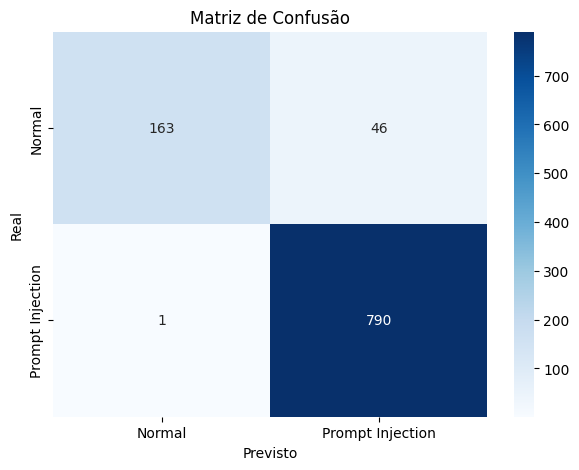

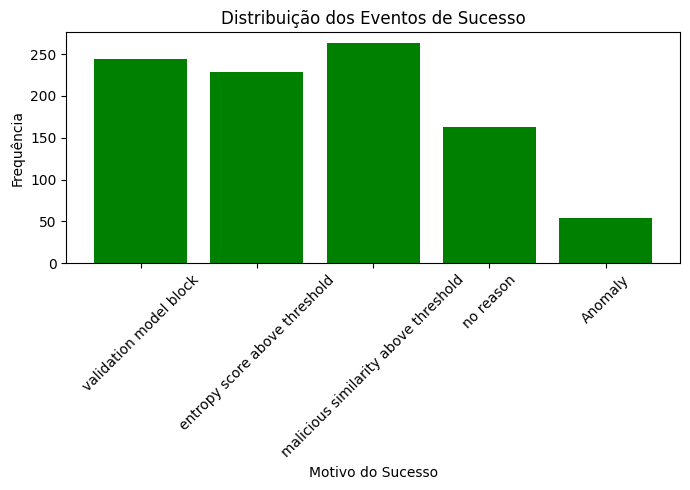

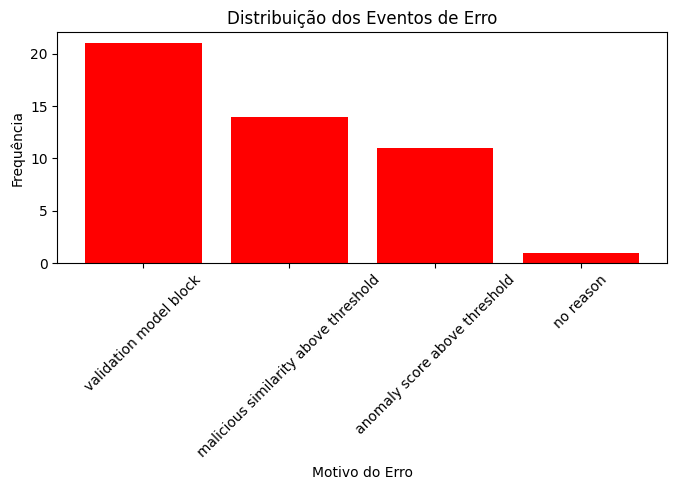

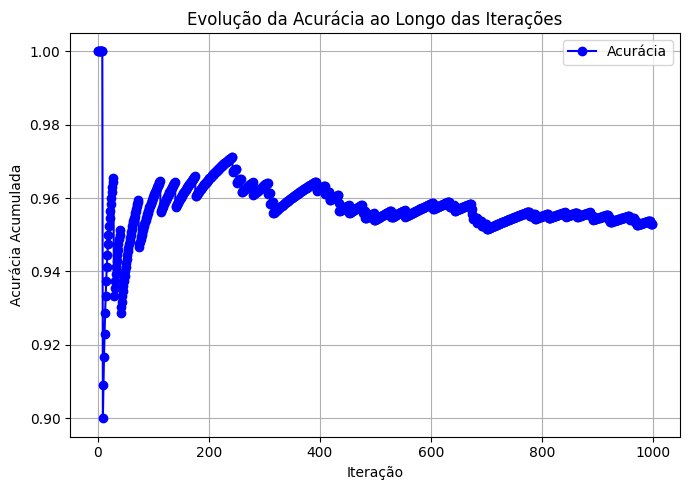

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Prompt Injection"],
            yticklabels=["Normal", "Prompt Injection"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Gráfico de barras para eventos de sucesso
plt.figure(figsize=(7, 5))
plt.bar(success_events.keys(), success_events.values(), color='g')
plt.xlabel("Motivo do Sucesso")
plt.ylabel("Frequência")
plt.title("Distribuição dos Eventos de Sucesso")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de barras para eventos de erro
plt.figure(figsize=(7, 5))
plt.bar(error_events.keys(), error_events.values(), color='r')
plt.xlabel("Motivo do Erro")
plt.ylabel("Frequência")
plt.title("Distribuição dos Eventos de Erro")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Evolução da acurácia
rolling_accuracy = np.cumsum(np.array(y_true) == np.array(y_pred)) / (np.arange(1, len(y_true) + 1))

plt.figure(figsize=(7, 5))
plt.plot(iterations, rolling_accuracy, marker='o', linestyle='-', color='b', label='Acurácia')
plt.xlabel("Iteração")
plt.ylabel("Acurácia Acumulada")
plt.title("Evolução da Acurácia ao Longo das Iterações")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


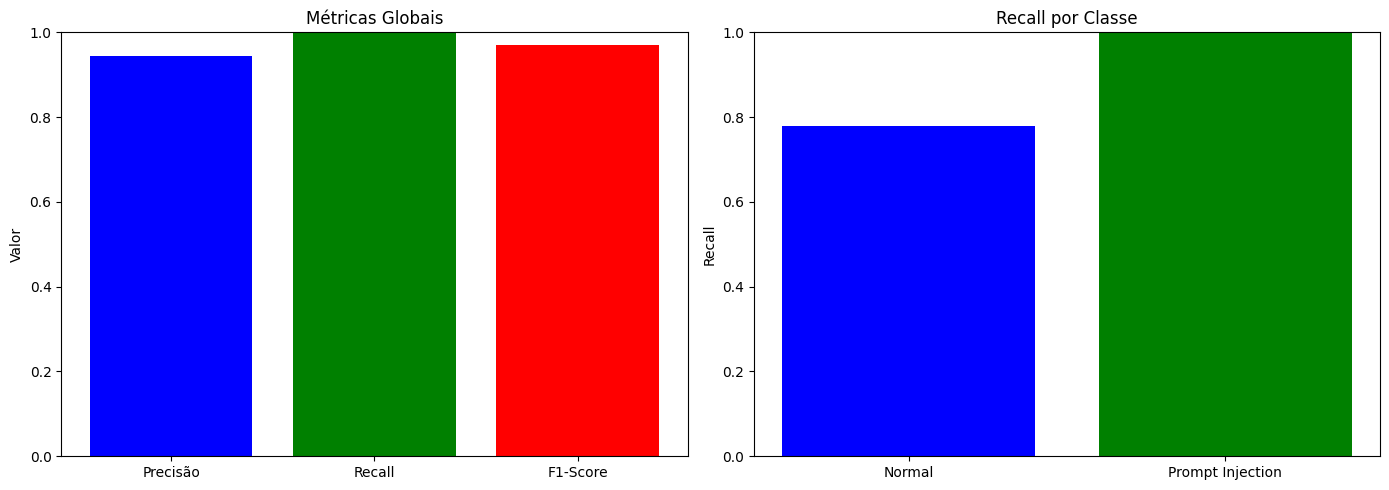

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Calcula métricas globais
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras para precisão, recall e F1
axs[0].bar(["Precisão", "Recall", "F1-Score"], [precision, recall, f1], color=['b', 'g', 'r'])
axs[0].set_ylabel("Valor")
axs[0].set_title("Métricas Globais")
axs[0].set_ylim(0, 1)

# Gráfico de recall por classe
recall_normal = recall_score(y_true, y_pred, pos_label=0)
recall_injection = recall_score(y_true, y_pred, pos_label=1)
axs[1].bar(["Normal", "Prompt Injection"], [recall_normal, recall_injection], color=['b', 'g'])
axs[1].set_ylabel("Recall")
axs[1].set_title("Recall por Classe")
axs[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()



In [17]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Inicializa pipeline
classifier = pipeline("text-classification", model="meta-llama/Prompt-Guard-86M")

# Dados
simulation = test_dataset[:1000]  # Ajuste o número conforme desejado

# Variáveis de rastreamento
y_true = []
y_pred = []
success_events = {}
error_events = {}

# Loop de validação
for index, row in simulation.iterrows():
    prompt = row["User Prompt"]
    classification = int(row["Prompt injection"])  # 1 = injection, 0 = benign

    result = classifier(prompt)
    model_prediction = result[0]['label']  # 'BENIGN', 'INJECTION', 'JAILBREAK', etc.

    # Mapeia a predição para binário
    predicted_label = 1 if model_prediction in ['INJECTION', 'JAILBREAK'] else 0

    y_true.append(classification)
    y_pred.append(predicted_label)

    # Eventos
    if classification == predicted_label:
        success_events[model_prediction] = success_events.get(model_prediction, 0) + 1
    else:
        error_events[model_prediction] = error_events.get(model_prediction, 0) + 1

# Métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred)


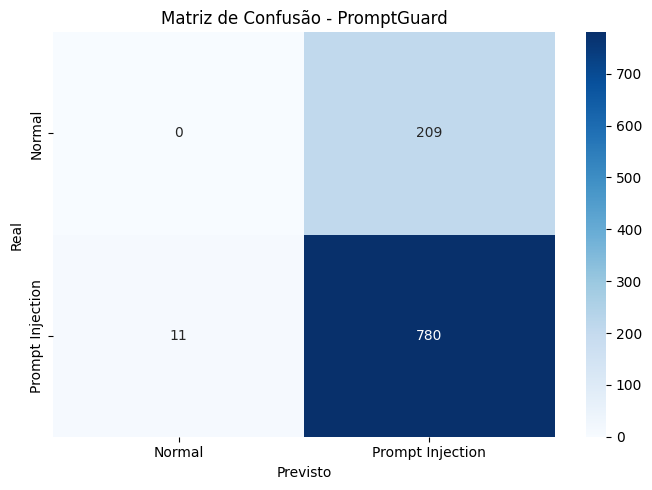

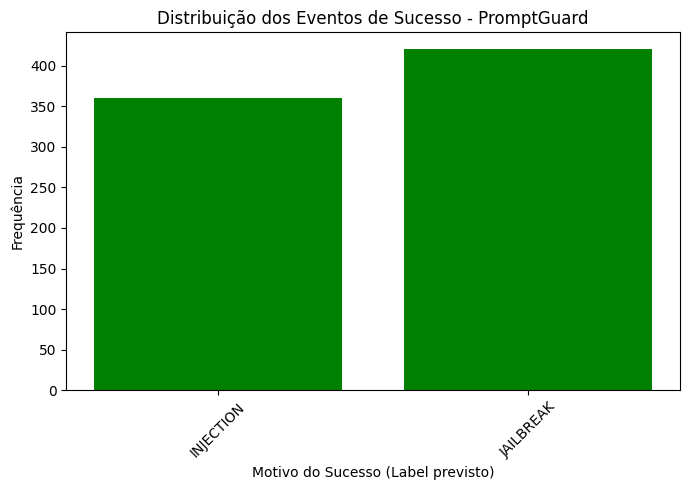

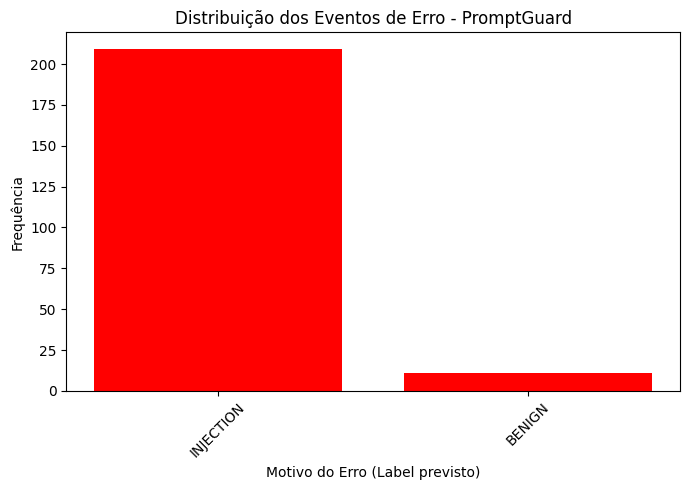

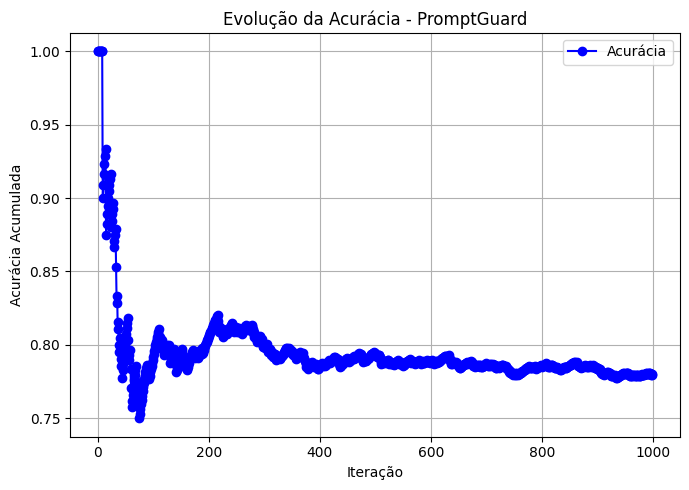

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Prompt Injection"],
            yticklabels=["Normal", "Prompt Injection"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - PromptGuard")
plt.tight_layout()
plt.show()

# Gráfico de barras para eventos de sucesso
plt.figure(figsize=(7, 5))
plt.bar(success_events.keys(), success_events.values(), color='g')
plt.xlabel("Motivo do Sucesso (Label previsto)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Eventos de Sucesso - PromptGuard")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de barras para eventos de erro
plt.figure(figsize=(7, 5))
plt.bar(error_events.keys(), error_events.values(), color='r')
plt.xlabel("Motivo do Erro (Label previsto)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Eventos de Erro - PromptGuard")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Evolução da acurácia
rolling_accuracy = np.cumsum(np.array(y_true) == np.array(y_pred)) / (np.arange(1, len(y_true) + 1))

plt.figure(figsize=(7, 5))
plt.plot(range(len(rolling_accuracy)), rolling_accuracy, marker='o', linestyle='-', color='b', label='Acurácia')
plt.xlabel("Iteração")
plt.ylabel("Acurácia Acumulada")
plt.title("Evolução da Acurácia - PromptGuard")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

